# Transaction Data — Anomaly Detection & Alerting Strategy

This notebook extends the exploratory analysis in `eda.ipynb` by implementing robust anomaly detection on the transaction data.

**What we detect:**
1. **Volume anomalies** — sudden drops or spikes in transaction counts
2. **Status distribution anomalies** — drops in approval rate, spikes in denials/failures
3. **Cross-signal anomalies** — divergence between transaction status and auth code patterns
4. **Recommended alerting strategy** for production monitoring

**Data:** Per-minute transaction counts by status and auth code, covering July 12–15, 2025.

## 1. Imports & Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (18, 6)
plt.rcParams['figure.dpi'] = 100

DATA_DIR = Path('../sample_data/transactions')

## 2. Data Loading

In [2]:
# Load transaction status data
df_trans = pd.read_csv(DATA_DIR / 'transactions.csv', parse_dates=['timestamp'])
df_trans = df_trans.sort_values('timestamp').reset_index(drop=True)

# Load auth code data
df_auth = pd.read_csv(DATA_DIR / 'transactions_auth_codes.csv', parse_dates=['timestamp'])
df_auth = df_auth.sort_values('timestamp').reset_index(drop=True)

print(f'Transaction status data: {df_trans.shape[0]} rows')
print(f'  Time range: {df_trans["timestamp"].min()} to {df_trans["timestamp"].max()}')
print(f'  Statuses: {df_trans["status"].unique().tolist()}')
print(f'\nAuth code data: {df_auth.shape[0]} rows')
print(f'  Time range: {df_auth["timestamp"].min()} to {df_auth["timestamp"].max()}')
print(f'  Auth codes: {sorted(df_auth["auth_code"].unique().tolist())}')

Transaction status data: 25920 rows
  Time range: 2025-07-12 13:45:00 to 2025-07-15 13:44:00
  Statuses: ['approved', 'backend_reversed', 'reversed', 'refunded', 'denied', 'failed']

Auth code data: 12960 rows
  Time range: 2025-07-12 13:45:00 to 2025-07-15 13:44:00
  Auth codes: [0, 51, 59]


## 3. Feature Engineering

Create time-series features needed for anomaly detection.

In [3]:
# Pivot: create a per-minute total volume and per-status columns
df_volume = df_trans.pivot_table(
    index='timestamp', columns='status', values='count', aggfunc='sum'
).fillna(0)

# Total volume per minute
df_volume['total'] = df_volume.sum(axis=1)

# Approval rate per minute
if 'approved' in df_volume.columns:
    df_volume['approval_rate'] = df_volume['approved'] / df_volume['total'].replace(0, np.nan)
else:
    df_volume['approval_rate'] = np.nan

# Denial + failure rate per minute
error_cols = [c for c in ['denied', 'failed'] if c in df_volume.columns]
if error_cols:
    df_volume['error_rate'] = df_volume[error_cols].sum(axis=1) / df_volume['total'].replace(0, np.nan)
else:
    df_volume['error_rate'] = 0.0

print(f'Volume time series: {len(df_volume)} timestamps')
print(f'Columns: {list(df_volume.columns)}')
print(f'\nVolume stats:')
print(df_volume[['total', 'approval_rate', 'error_rate']].describe().round(4))

Volume time series: 4320 timestamps
Columns: ['approved', 'backend_reversed', 'denied', 'failed', 'refunded', 'reversed', 'total', 'approval_rate', 'error_rate']

Volume stats:
status      total  approval_rate  error_rate
count   4320.0000      4320.0000   4320.0000
mean     126.0000         0.9260      0.0564
std       12.8911         0.0473      0.0450
min       67.0000         0.5748      0.0000
25%      118.0000         0.9174      0.0340
50%      126.0000         0.9353      0.0476
75%      134.0000         0.9504      0.0635
max      167.0000         1.0000      0.4035


In [4]:
# Auth code pivot
df_auth_pivot = df_auth.pivot_table(
    index='timestamp', columns='auth_code', values='count', aggfunc='sum'
).fillna(0)

df_auth_pivot['total'] = df_auth_pivot.sum(axis=1)

# Code '00' is typically the approval code
if '00' in df_auth_pivot.columns:
    df_auth_pivot['auth_approval_rate'] = df_auth_pivot['00'] / df_auth_pivot['total'].replace(0, np.nan)
elif 0 in df_auth_pivot.columns:
    df_auth_pivot['auth_approval_rate'] = df_auth_pivot[0] / df_auth_pivot['total'].replace(0, np.nan)
else:
    # Find the code with the highest total (likely approval)
    code_cols = [c for c in df_auth_pivot.columns if c not in ['total']]
    approval_code = df_auth_pivot[code_cols].sum().idxmax()
    df_auth_pivot['auth_approval_rate'] = df_auth_pivot[approval_code] / df_auth_pivot['total'].replace(0, np.nan)
    print(f'Using auth code "{approval_code}" as approval code (highest volume)')

print(f'Auth code time series: {len(df_auth_pivot)} timestamps')
print(f'\nAuth approval rate stats:')
print(df_auth_pivot['auth_approval_rate'].describe())

Auth code time series: 4320 timestamps

Auth approval rate stats:
count    4320.000000
mean        0.943102
std         0.045636
min         0.589286
25%         0.936000
50%         0.951669
75%         0.965517
max         1.000000
Name: auth_approval_rate, dtype: float64


## 4. Anomaly Detection — Rolling Z-Score Method

### Why rolling statistics work well for per-minute data

Unlike the checkout data (which only has hourly snapshots with pre-computed averages), the transaction data has **per-minute granularity over 3+ days**. This gives us enough data to compute robust rolling statistics.

**Our approach:**
- Use a **rolling window** (e.g., 60 minutes) to compute mean and std
- Calculate **Z-score** = (value - rolling_mean) / rolling_std
- Flag values where |Z| > threshold

This adapts to the time-of-day pattern naturally — if volume is low at night, the thresholds adjust accordingly.

In [5]:
def rolling_zscore_anomalies(series, window=60, z_threshold=3.0, min_periods=30):
    """
    Detect anomalies using rolling Z-score.
    
    Parameters:
    -----------
    series : pd.Series, the time series to analyze
    window : int, rolling window size in number of observations (minutes)
    z_threshold : float, Z-score threshold for anomaly detection
    min_periods : int, minimum observations in window for valid computation
    
    Returns:
    --------
    DataFrame with rolling stats and anomaly flags
    """
    result = pd.DataFrame(index=series.index)
    result['value'] = series
    
    # Rolling statistics
    result['rolling_mean'] = series.rolling(window=window, min_periods=min_periods, center=False).mean()
    result['rolling_std'] = series.rolling(window=window, min_periods=min_periods, center=False).std()
    
    # Floor std to avoid division by zero
    result['rolling_std'] = result['rolling_std'].clip(lower=1.0)
    
    # Z-score
    result['z_score'] = (result['value'] - result['rolling_mean']) / result['rolling_std']
    
    # Anomaly flags
    result['is_anomaly'] = result['z_score'].abs() > z_threshold
    result['is_spike'] = result['z_score'] > z_threshold
    result['is_drop'] = result['z_score'] < -z_threshold
    
    return result

### 4.1 Volume Anomaly Detection

In [6]:
# Detect anomalies in total transaction volume
volume_anomalies = rolling_zscore_anomalies(
    df_volume['total'], 
    window=60,      # 1-hour rolling window
    z_threshold=3.0  # 3σ = ~99.7% confidence
)

n_volume_anomalies = volume_anomalies['is_anomaly'].sum()
n_spikes = volume_anomalies['is_spike'].sum()
n_drops = volume_anomalies['is_drop'].sum()
total_points = len(volume_anomalies)

print(f'=== Volume Anomaly Detection ===')
print(f'Total data points: {total_points}')
print(f'Anomalies detected: {n_volume_anomalies} ({n_volume_anomalies/total_points*100:.2f}%)')
print(f'  - Spikes: {n_spikes}')
print(f'  - Drops:  {n_drops}')

if n_volume_anomalies > 0:
    print(f'\nAnomaly timestamps:')
    anomaly_times = volume_anomalies[volume_anomalies['is_anomaly']]
    for ts, row in anomaly_times.iterrows():
        direction = '📈 SPIKE' if row['is_spike'] else '📉 DROP'
        print(f'  {ts} | {direction} | value={row["value"]:.0f} | expected={row["rolling_mean"]:.1f} | Z={row["z_score"]:+.2f}')

=== Volume Anomaly Detection ===
Total data points: 4320
Anomalies detected: 12 (0.28%)
  - Spikes: 4
  - Drops:  8

Anomaly timestamps:
  2025-07-12 15:48:00 | 📉 DROP | value=91 | expected=128.8 | Z=-3.27
  2025-07-13 08:49:00 | 📉 DROP | value=82 | expected=124.3 | Z=-3.13
  2025-07-13 16:03:00 | 📉 DROP | value=79 | expected=125.4 | Z=-3.58
  2025-07-13 20:32:00 | 📈 SPIKE | value=167 | expected=126.9 | Z=+3.76
  2025-07-14 03:43:00 | 📉 DROP | value=84 | expected=126.3 | Z=-3.19
  2025-07-14 03:44:00 | 📉 DROP | value=82 | expected=125.3 | Z=-3.03
  2025-07-14 04:42:00 | 📈 SPIKE | value=136 | expected=99.0 | Z=+3.62
  2025-07-14 04:45:00 | 📈 SPIKE | value=137 | expected=100.6 | Z=+3.18
  2025-07-14 11:42:00 | 📉 DROP | value=67 | expected=125.8 | Z=-4.30
  2025-07-14 23:21:00 | 📉 DROP | value=81 | expected=129.6 | Z=-3.99
  2025-07-14 23:22:00 | 📉 DROP | value=89 | expected=128.8 | Z=-3.01
  2025-07-15 06:41:00 | 📈 SPIKE | value=156 | expected=126.2 | Z=+3.39


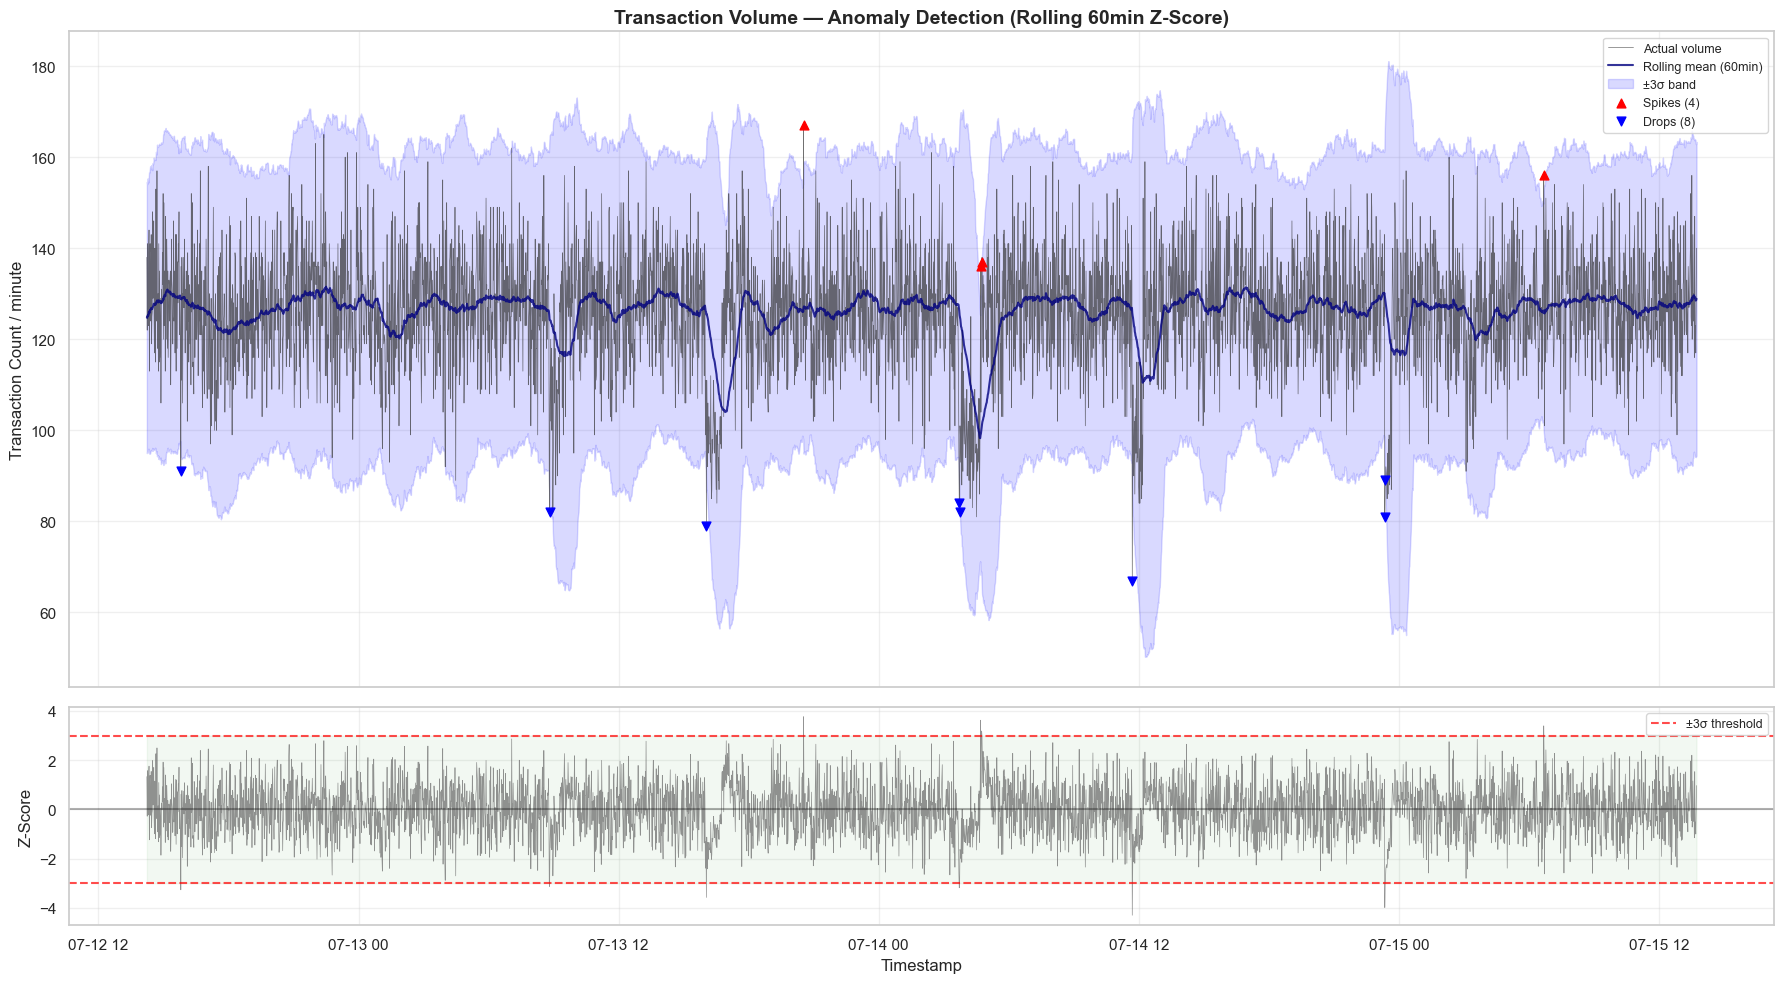

In [7]:
# Visualize volume with anomaly bands
fig, axes = plt.subplots(2, 1, figsize=(18, 10), sharex=True, 
                         gridspec_kw={'height_ratios': [3, 1]})

# Top panel: Volume with confidence bands
ax = axes[0]
va = volume_anomalies.dropna()
ax.plot(va.index, va['value'], linewidth=0.5, alpha=0.7, color='#333333', label='Actual volume')
ax.plot(va.index, va['rolling_mean'], linewidth=1.5, color='navy', label='Rolling mean (60min)', alpha=0.8)

upper = va['rolling_mean'] + 3 * va['rolling_std']
lower = (va['rolling_mean'] - 3 * va['rolling_std']).clip(lower=0)
ax.fill_between(va.index, lower, upper, alpha=0.15, color='blue', label='±3σ band')

# Mark anomalies
spikes = va[va['is_spike']]
drops = va[va['is_drop']]
if len(spikes) > 0:
    ax.scatter(spikes.index, spikes['value'], color='red', s=40, zorder=5, label=f'Spikes ({len(spikes)})', marker='^')
if len(drops) > 0:
    ax.scatter(drops.index, drops['value'], color='blue', s=40, zorder=5, label=f'Drops ({len(drops)})', marker='v')

ax.set_ylabel('Transaction Count / minute')
ax.set_title('Transaction Volume — Anomaly Detection (Rolling 60min Z-Score)', fontsize=14, fontweight='bold')
ax.legend(fontsize=9, loc='upper right')
ax.grid(True, alpha=0.3)

# Bottom panel: Z-score
ax2 = axes[1]
ax2.plot(va.index, va['z_score'], linewidth=0.5, color='#666666', alpha=0.7)
ax2.axhline(y=3.0, color='red', linestyle='--', alpha=0.7, label='±3σ threshold')
ax2.axhline(y=-3.0, color='red', linestyle='--', alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.fill_between(va.index, -3, 3, alpha=0.05, color='green')
ax2.set_ylabel('Z-Score')
ax2.set_xlabel('Timestamp')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.2 Approval Rate Anomaly Detection

In [8]:
# Detect anomalies in approval rate
approval_anomalies = rolling_zscore_anomalies(
    df_volume['approval_rate'].dropna(),
    window=60,
    z_threshold=2.5  # Slightly more sensitive for approval rate
)

n_approval_anomalies = approval_anomalies['is_anomaly'].sum()
print(f'=== Approval Rate Anomaly Detection ===')
print(f'Anomalies detected: {n_approval_anomalies}')
print(f'  - Rate too high: {approval_anomalies["is_spike"].sum()}')
print(f'  - Rate too low:  {approval_anomalies["is_drop"].sum()}')

if n_approval_anomalies > 0:
    print(f'\nApproval rate anomaly details:')
    anomaly_times = approval_anomalies[approval_anomalies['is_anomaly']]
    for ts, row in anomaly_times.head(20).iterrows():  # Show first 20
        direction = '⬆️ HIGH' if row['is_spike'] else '⬇️ LOW'
        print(f'  {ts} | {direction} | rate={row["value"]:.4f} | expected={row["rolling_mean"]:.4f} | Z={row["z_score"]:+.2f}')
    if len(anomaly_times) > 20:
        print(f'  ... and {len(anomaly_times) - 20} more')

=== Approval Rate Anomaly Detection ===
Anomalies detected: 0
  - Rate too high: 0
  - Rate too low:  0


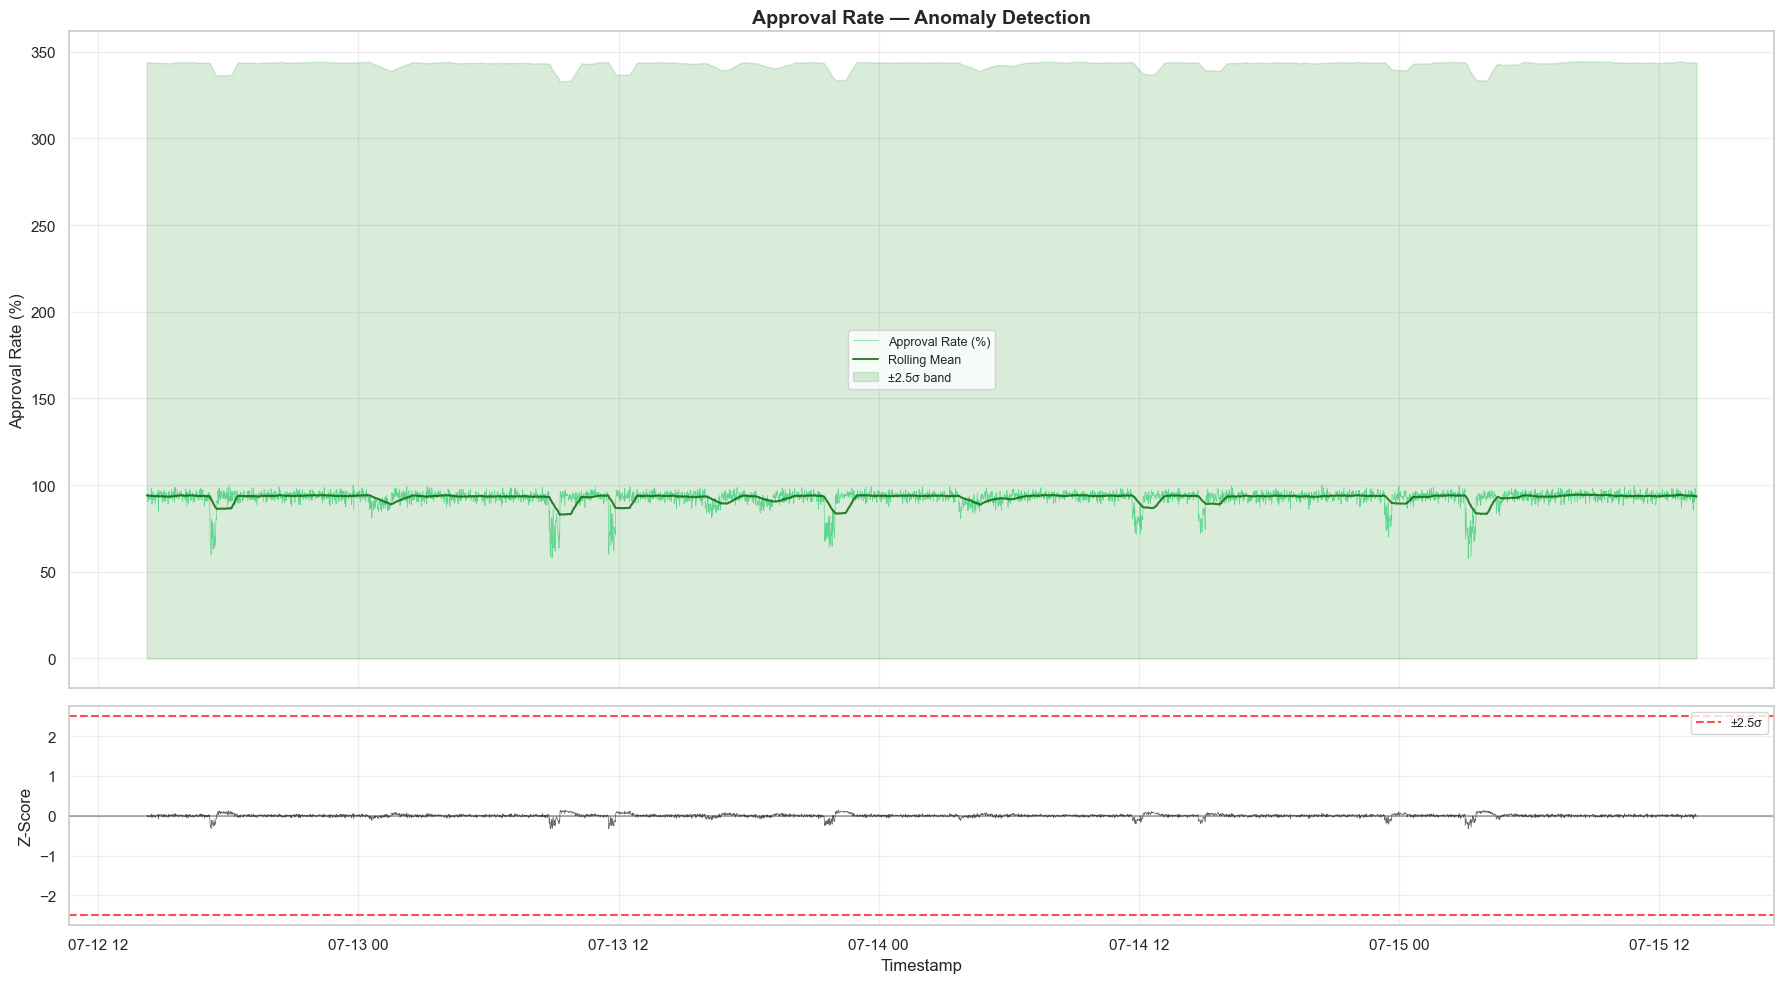

In [9]:
# Visualize approval rate anomalies
fig, axes = plt.subplots(2, 1, figsize=(18, 10), sharex=True,
                         gridspec_kw={'height_ratios': [3, 1]})

aa = approval_anomalies.dropna()

# Top: approval rate
ax = axes[0]
ax.plot(aa.index, aa['value'] * 100, linewidth=0.5, alpha=0.7, color='#2ecc71', label='Approval Rate (%)')
ax.plot(aa.index, aa['rolling_mean'] * 100, linewidth=1.5, color='darkgreen', label='Rolling Mean', alpha=0.8)

upper = (aa['rolling_mean'] + 2.5 * aa['rolling_std']) * 100
lower = (aa['rolling_mean'] - 2.5 * aa['rolling_std']).clip(lower=0) * 100
ax.fill_between(aa.index, lower, upper, alpha=0.15, color='green', label='±2.5σ band')

# Mark anomalies
drops = aa[aa['is_drop']]
if len(drops) > 0:
    ax.scatter(drops.index, drops['value'] * 100, color='red', s=30, zorder=5, 
               label=f'Low approval ({len(drops)})', marker='v')

ax.set_ylabel('Approval Rate (%)')
ax.set_title('Approval Rate — Anomaly Detection', fontsize=14, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Bottom: Z-score
ax2 = axes[1]
ax2.plot(aa.index, aa['z_score'], linewidth=0.5, color='#666666')
ax2.axhline(y=2.5, color='red', linestyle='--', alpha=0.7, label='±2.5σ')
ax2.axhline(y=-2.5, color='red', linestyle='--', alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.set_ylabel('Z-Score')
ax2.set_xlabel('Timestamp')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.3 Error Rate Anomaly Detection

In [10]:
# Detect anomalies in error rate (denied + failed)
error_anomalies = rolling_zscore_anomalies(
    df_volume['error_rate'].dropna(),
    window=60,
    z_threshold=2.5
)

n_error_anomalies = error_anomalies['is_anomaly'].sum()
n_error_spikes = error_anomalies['is_spike'].sum()
print(f'=== Error Rate Anomaly Detection ===')
print(f'Anomalies detected: {n_error_anomalies}')
print(f'  - Error rate spikes: {n_error_spikes}')

if n_error_spikes > 0:
    print(f'\nError rate spike details:')
    spikes = error_anomalies[error_anomalies['is_spike']]
    for ts, row in spikes.head(20).iterrows():
        print(f'  {ts} | rate={row["value"]:.4f} | expected={row["rolling_mean"]:.4f} | Z={row["z_score"]:+.2f}')
    if len(spikes) > 20:
        print(f'  ... and {len(spikes) - 20} more')

=== Error Rate Anomaly Detection ===
Anomalies detected: 0
  - Error rate spikes: 0


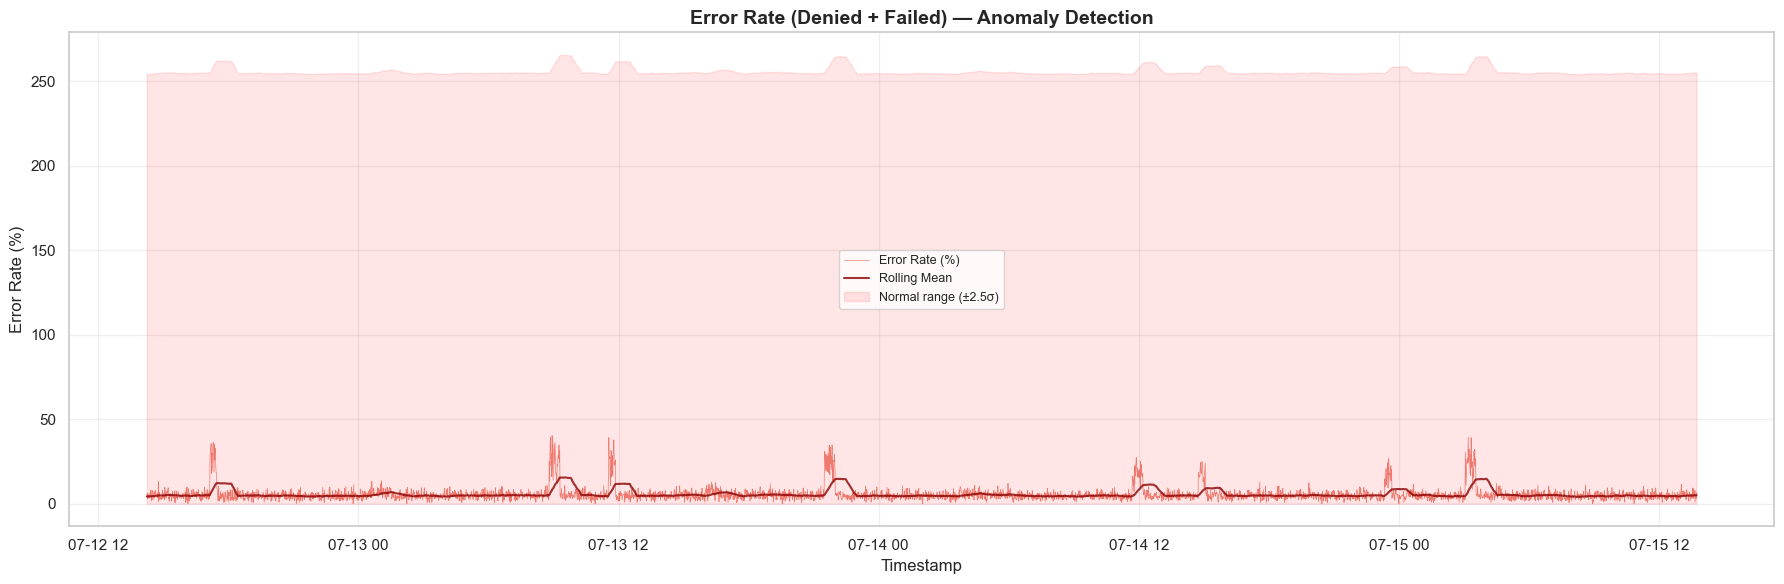

In [11]:
# Visualize error rate anomalies
fig, ax = plt.subplots(figsize=(18, 6))

ea = error_anomalies.dropna()
ax.plot(ea.index, ea['value'] * 100, linewidth=0.5, alpha=0.7, color='#e74c3c', label='Error Rate (%)')
ax.plot(ea.index, ea['rolling_mean'] * 100, linewidth=1.5, color='darkred', label='Rolling Mean', alpha=0.8)

upper = (ea['rolling_mean'] + 2.5 * ea['rolling_std']) * 100
ax.fill_between(ea.index, 0, upper, alpha=0.1, color='red', label='Normal range (±2.5σ)')

spikes = ea[ea['is_spike']]
if len(spikes) > 0:
    ax.scatter(spikes.index, spikes['value'] * 100, color='red', s=50, zorder=5,
               marker='^', edgecolors='black', linewidths=0.5, label=f'Spikes ({len(spikes)})')

ax.set_ylabel('Error Rate (%)')
ax.set_xlabel('Timestamp')
ax.set_title('Error Rate (Denied + Failed) — Anomaly Detection', fontsize=14, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Cross-Signal Anomaly Detection

Check if the approval rate from transaction statuses diverges from the auth code approval rate. A significant divergence could indicate data pipeline issues or inconsistencies.

In [12]:
# Merge the two approval rate signals
df_cross = pd.DataFrame({
    'status_approval_rate': df_volume['approval_rate'],
    'auth_approval_rate': df_auth_pivot['auth_approval_rate']
})

# Compute divergence
df_cross['divergence'] = (df_cross['status_approval_rate'] - df_cross['auth_approval_rate']).abs()
df_cross = df_cross.dropna()

print('=== Cross-Signal Analysis ===')
print(f'Data points with both signals: {len(df_cross)}')
print(f'\nDivergence statistics:')
print(df_cross['divergence'].describe().round(6))

# Flag significant divergences
divergence_threshold = df_cross['divergence'].mean() + 3 * df_cross['divergence'].std()
df_cross['is_divergent'] = df_cross['divergence'] > divergence_threshold
n_divergent = df_cross['is_divergent'].sum()

print(f'\nDivergence threshold (mean + 3σ): {divergence_threshold:.6f}')
print(f'Divergent timestamps: {n_divergent}')

if n_divergent > 0:
    print(f'\nDivergent moments:')
    for ts, row in df_cross[df_cross['is_divergent']].head(20).iterrows():
        print(f'  {ts} | status_rate={row["status_approval_rate"]:.4f} | auth_rate={row["auth_approval_rate"]:.4f} | diff={row["divergence"]:.4f}')

=== Cross-Signal Analysis ===
Data points with both signals: 4320

Divergence statistics:
count    4320.000000
mean        0.017143
std         0.014165
min         0.000000
25%         0.007454
50%         0.014904
75%         0.023150
max         0.125217
Name: divergence, dtype: float64

Divergence threshold (mean + 3σ): 0.059638
Divergent timestamps: 70

Divergent moments:
  2025-07-13 00:31:00 | status_rate=0.8571 | auth_rate=0.9273 | diff=0.0701
  2025-07-13 00:37:00 | status_rate=0.8099 | auth_rate=0.8991 | diff=0.0892
  2025-07-13 00:38:00 | status_rate=0.8582 | auth_rate=0.9350 | diff=0.0768
  2025-07-13 00:42:00 | status_rate=0.8562 | auth_rate=0.9161 | diff=0.0599
  2025-07-13 00:45:00 | status_rate=0.8740 | auth_rate=0.9487 | diff=0.0747
  2025-07-13 00:47:00 | status_rate=0.8667 | auth_rate=0.9435 | diff=0.0769
  2025-07-13 00:49:00 | status_rate=0.9040 | auth_rate=0.9658 | diff=0.0618
  2025-07-13 00:54:00 | status_rate=0.8740 | auth_rate=0.9737 | diff=0.0997
  2025-07-13

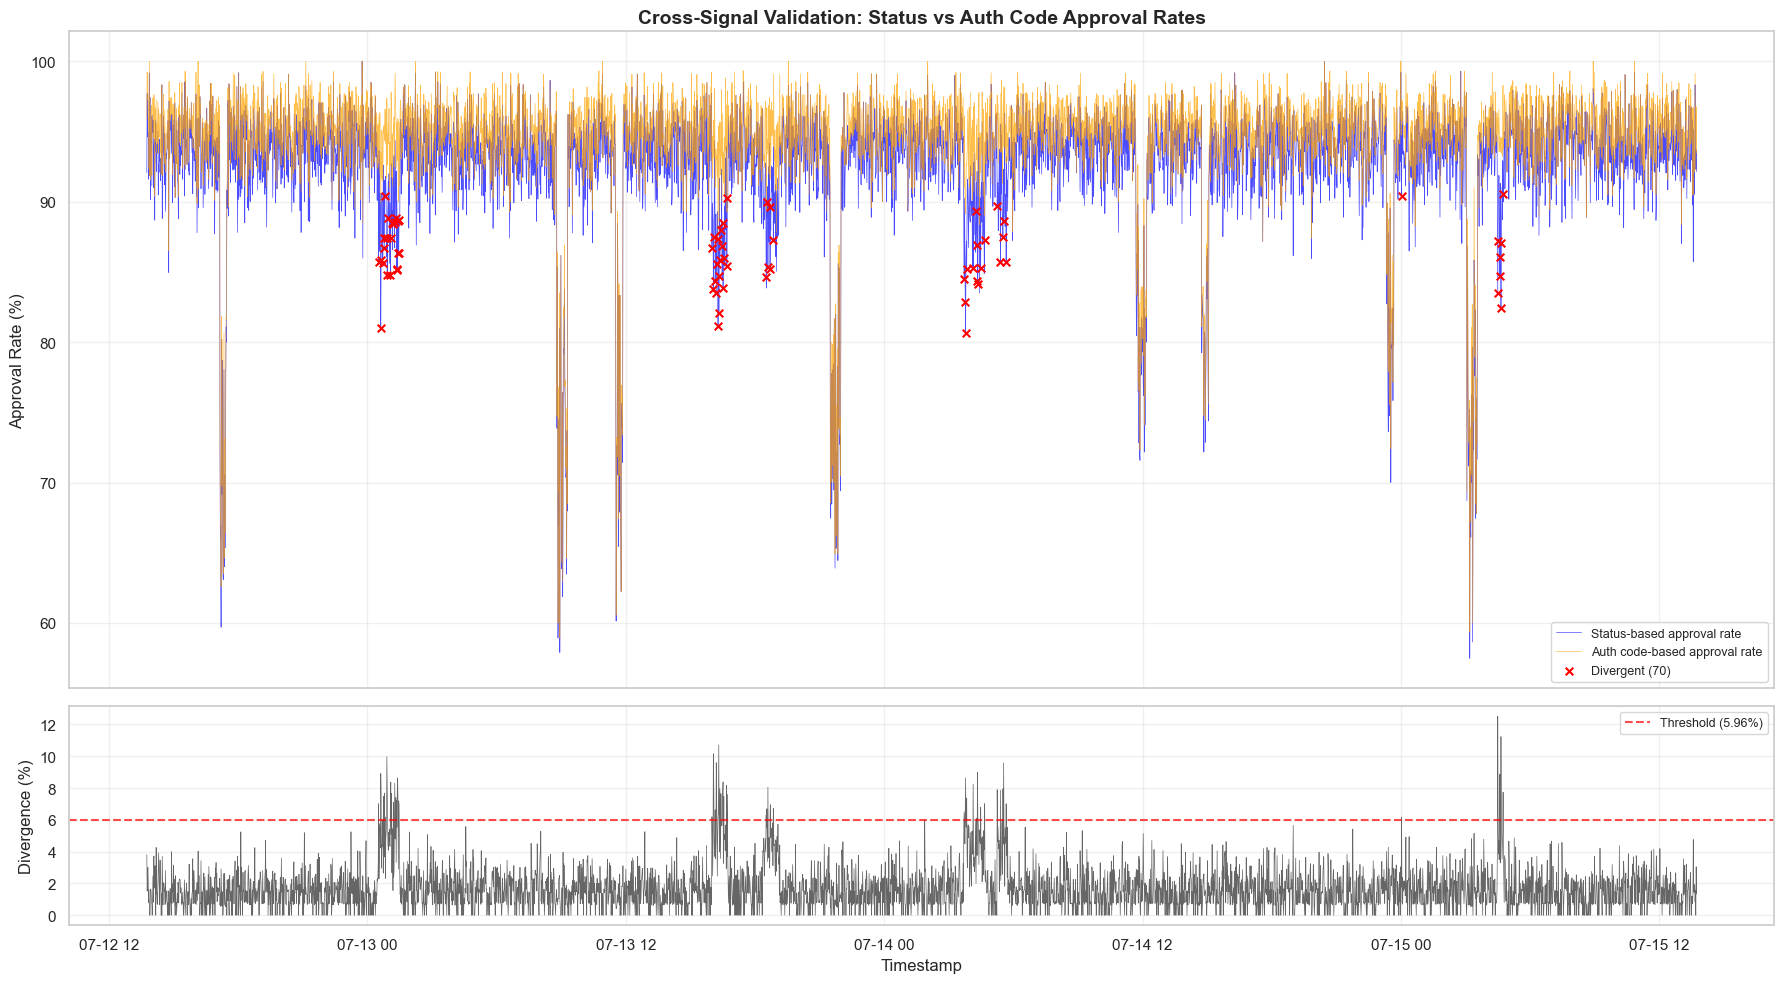

In [13]:
# Visualize cross-signal comparison
fig, axes = plt.subplots(2, 1, figsize=(18, 10), sharex=True,
                         gridspec_kw={'height_ratios': [3, 1]})

# Top: Both approval rates
ax = axes[0]
ax.plot(df_cross.index, df_cross['status_approval_rate'] * 100, 
        linewidth=0.5, alpha=0.7, color='blue', label='Status-based approval rate')
ax.plot(df_cross.index, df_cross['auth_approval_rate'] * 100,
        linewidth=0.5, alpha=0.7, color='orange', label='Auth code-based approval rate')

divergent = df_cross[df_cross['is_divergent']]
if len(divergent) > 0:
    ax.scatter(divergent.index, divergent['status_approval_rate'] * 100,
               color='red', s=30, zorder=5, marker='x', label=f'Divergent ({len(divergent)})')

ax.set_ylabel('Approval Rate (%)')
ax.set_title('Cross-Signal Validation: Status vs Auth Code Approval Rates', fontsize=14, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Bottom: Divergence
ax2 = axes[1]
ax2.plot(df_cross.index, df_cross['divergence'] * 100, linewidth=0.5, color='#666666')
ax2.axhline(y=divergence_threshold * 100, color='red', linestyle='--', alpha=0.7, label=f'Threshold ({divergence_threshold*100:.2f}%)')
ax2.set_ylabel('Divergence (%)')
ax2.set_xlabel('Timestamp')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Drop-to-Zero / Near-Zero Detection

In [14]:
# Detect periods where volume drops to zero or near-zero
# This is independent of Z-score — it catches complete outages

zero_threshold = 5  # Less than 5 transactions/minute = potential outage
df_outages = df_volume[df_volume['total'] <= zero_threshold].copy()

print(f'=== Drop-to-Zero / Near-Zero Detection ===')
print(f'Minutes with ≤ {zero_threshold} transactions: {len(df_outages)}')

if len(df_outages) > 0:
    # Group consecutive outage minutes into periods
    outage_periods = []
    current_start = None
    current_end = None
    
    for ts in df_outages.index:
        if current_start is None:
            current_start = ts
            current_end = ts
        elif (ts - current_end) <= pd.Timedelta(minutes=2):  # Allow 1-minute gap
            current_end = ts
        else:
            duration = (current_end - current_start).total_seconds() / 60 + 1
            outage_periods.append((current_start, current_end, duration))
            current_start = ts
            current_end = ts
    
    if current_start is not None:
        duration = (current_end - current_start).total_seconds() / 60 + 1
        outage_periods.append((current_start, current_end, duration))
    
    print(f'\nDistinct low-volume periods: {len(outage_periods)}')
    for start, end, dur in outage_periods:
        avg_vol = df_volume.loc[start:end, 'total'].mean()
        severity = '🔴 CRITICAL' if dur >= 5 else '🟡 WARNING' if dur >= 2 else '🟢 INFO'
        print(f'  {severity} | {start} to {end} | Duration: {dur:.0f} min | Avg volume: {avg_vol:.1f}')
else:
    print('\nNo zero/near-zero periods detected. ✅')

=== Drop-to-Zero / Near-Zero Detection ===
Minutes with ≤ 5 transactions: 0

No zero/near-zero periods detected. ✅


## 7. Consolidated Anomaly Summary

In [15]:
print('=' * 80)
print('ANOMALY DETECTION SUMMARY')
print('=' * 80)

# Create a unified anomaly timeline
all_timestamps = df_volume.index
anomaly_summary = pd.DataFrame(index=all_timestamps)
anomaly_summary['volume_zscore'] = volume_anomalies['z_score']
anomaly_summary['volume_anomaly'] = volume_anomalies['is_anomaly'].astype(int)
anomaly_summary['approval_zscore'] = approval_anomalies['z_score']
anomaly_summary['approval_anomaly'] = approval_anomalies['is_anomaly'].astype(int)
anomaly_summary['error_zscore'] = error_anomalies['z_score'] 
anomaly_summary['error_anomaly'] = error_anomalies['is_anomaly'].astype(int)
anomaly_summary['cross_signal_divergent'] = 0
anomaly_summary.loc[df_cross[df_cross['is_divergent']].index, 'cross_signal_divergent'] = 1
anomaly_summary['near_zero'] = 0
anomaly_summary.loc[df_outages.index, 'near_zero'] = 1

# Combined score
anomaly_summary['total_score'] = (
    anomaly_summary['volume_anomaly'] + 
    anomaly_summary['approval_anomaly'] +
    anomaly_summary['error_anomaly'] +
    anomaly_summary['cross_signal_divergent'] +
    anomaly_summary['near_zero'] * 2  # Near-zero counts double
)

# Classification
def classify_transaction_anomaly(score, near_zero):
    if near_zero:
        return 'CRITICAL'
    if score >= 3:
        return 'CRITICAL'
    if score >= 2:
        return 'WARNING'
    if score >= 1:
        return 'INFO'
    return 'NORMAL'

anomaly_summary['severity'] = anomaly_summary.apply(
    lambda r: classify_transaction_anomaly(r['total_score'], r['near_zero']),
    axis=1
)

# Report
severity_counts = anomaly_summary['severity'].value_counts()
print(f'\nSeverity distribution:')
for sev in ['CRITICAL', 'WARNING', 'INFO', 'NORMAL']:
    count = severity_counts.get(sev, 0)
    pct = count / len(anomaly_summary) * 100
    print(f'  {sev:>10}: {count:>6} ({pct:.2f}%)')

# Show critical and warning events
critical_warning = anomaly_summary[anomaly_summary['severity'].isin(['CRITICAL', 'WARNING'])]
if len(critical_warning) > 0:
    print(f'\nCRITICAL/WARNING events ({len(critical_warning)} total):')
    for ts, row in critical_warning.head(30).iterrows():
        flags = []
        if row['volume_anomaly']: flags.append('VOL')
        if row['approval_anomaly']: flags.append('APR')
        if row['error_anomaly']: flags.append('ERR')
        if row['cross_signal_divergent']: flags.append('XSIG')
        if row['near_zero']: flags.append('OUTAGE')
        print(f'  {ts} | {row["severity"]:>8} | score={row["total_score"]} | triggers: {", ".join(flags)}')
    if len(critical_warning) > 30:
        print(f'  ... and {len(critical_warning) - 30} more')
else:
    print(f'\nNo CRITICAL or WARNING events detected ✅')

ANOMALY DETECTION SUMMARY

Severity distribution:
    CRITICAL:      0 (0.00%)
        INFO:     80 (1.85%)
      NORMAL:   4239 (98.12%)

CRITICAL/WARNING events (1 total):
  2025-07-14 03:43:00 |  WARNING | score=2 | triggers: VOL, XSIG


## 8. Alerting Strategy Recommendations

In [16]:
# Compute recommended thresholds from the data
vol_mean = df_volume['total'].mean()
vol_std = df_volume['total'].std()
apr_mean = df_volume['approval_rate'].mean()
apr_std = df_volume['approval_rate'].std()
err_mean = df_volume['error_rate'].mean()
err_std = df_volume['error_rate'].std()

print('=' * 80)
print('RECOMMENDED ALERTING STRATEGY FOR PRODUCTION')
print('=' * 80)

strategy = f"""
┌─────────────────────────────────────────────────────────────────────────────────┐
│                        TRANSACTION MONITORING RULES                             │
├─────────────────────────────────────────────────────────────────────────────────┤
│                                                                                 │
│  📊 VOLUME MONITORING (per-minute)                                              │
│  ─────────────────────────────────                                              │
│  • Expected: ~{vol_mean:.0f} txn/min (σ = {vol_std:.1f})                        │
│  • Method: Rolling 60-min Z-score                                               │
│  • CRITICAL alert if: volume < 5 txn/min for ≥ 5 consecutive minutes           │
│  • WARNING alert if:  |Z| > 3.0 (equivalent to ~{vol_mean-3*vol_std:.0f} or ~{vol_mean+3*vol_std:.0f} txn/min)│
│  • Check frequency: Every minute                                               │
│                                                                                 │
│  ✅ APPROVAL RATE MONITORING                                                    │
│  ──────────────────────────────                                                 │
│  • Expected: ~{apr_mean*100:.1f}% (σ = {apr_std*100:.2f}%)                      │
│  • Method: Rolling 60-min Z-score                                               │
│  • CRITICAL alert if: approval rate < {max(0, (apr_mean-3*apr_std))*100:.1f}%                               │
│  • WARNING alert if:  Z < -2.5 (approval rate dropping)                        │
│  • Check frequency: Every 5 minutes                                            │
│                                                                                 │
│  ❌ ERROR RATE MONITORING                                                       │
│  ────────────────────────────                                                   │
│  • Expected: ~{err_mean*100:.2f}% (σ = {err_std*100:.2f}%)                      │
│  • Method: Rolling 60-min Z-score                                               │
│  • WARNING alert if: Z > 2.5 (errors rising)                                   │
│  • Check frequency: Every 5 minutes                                            │
│                                                                                 │
│  🔄 CROSS-SIGNAL VALIDATION                                                    │
│  ──────────────────────────────                                                 │
│  • Compare: status-based vs auth-code-based approval rates                     │
│  • WARNING if: divergence > {divergence_threshold*100:.2f}% (mean + 3σ)         │
│  • Indicates: possible data pipeline issues                                    │
│  • Check frequency: Every 15 minutes                                           │
│                                                                                 │
└─────────────────────────────────────────────────────────────────────────────────┘

MONITORING CADENCE:
  • Every 1 min:  Volume drop-to-zero check
  • Every 5 min:  Rolling Z-score for volume, approval rate, error rate
  • Every 15 min: Cross-signal divergence check
  • Every 1 hour: Full anomaly report

TUNING RECOMMENDATIONS:
  • Z=3.0 for volume → catches ~0.3%% of points as anomalous (very conservative)
  • Z=2.5 for rates → slightly more sensitive for business-critical metrics
  • Adjust window size (currently 60min) based on business cadence
  • Consider day-of-week seasonality for tighter thresholds

ESCALATION PATH:
  1. INFO alerts  → Log for analysis, no immediate action
  2. WARNING      → Notify on-call team within 15 minutes
  3. CRITICAL     → Page on-call immediately, begin incident response
"""
print(strategy)

RECOMMENDED ALERTING STRATEGY FOR PRODUCTION

┌─────────────────────────────────────────────────────────────────────────────────┐
│                        TRANSACTION MONITORING RULES                             │
├─────────────────────────────────────────────────────────────────────────────────┤
│                                                                                 │
│  📊 VOLUME MONITORING (per-minute)                                              │
│  ─────────────────────────────────                                              │
│  • Expected: ~126 txn/min (σ = 12.9)                        │
│  • Method: Rolling 60-min Z-score                                               │
│  • CRITICAL alert if: volume < 5 txn/min for ≥ 5 consecutive minutes           │
│  • WARNING alert if:  |Z| > 3.0 (equivalent to ~87 or ~165 txn/min)│
│  • Check frequency: Every minute                                               │
│                                                                 

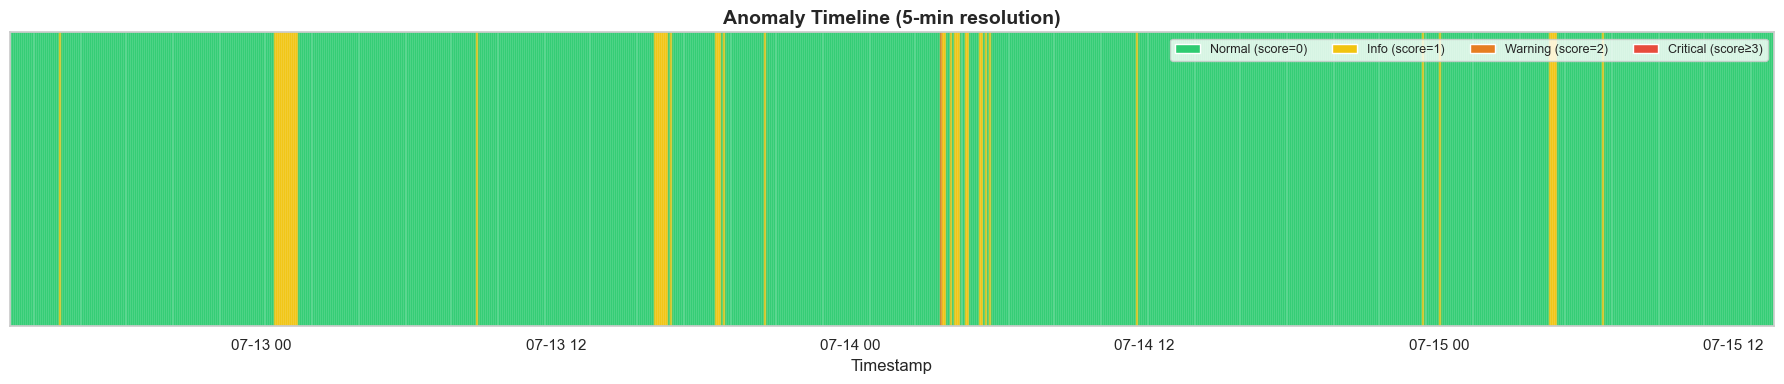


✅ Anomaly detection complete. Review the flagged events above for investigation.


In [17]:
# Final visualization: anomaly timeline heatmap
fig, ax = plt.subplots(figsize=(18, 4))

# Resample anomaly score to 5-minute windows for cleaner visualization
anomaly_timeline = anomaly_summary['total_score'].resample('5min').max().fillna(0)

# Plot as a color bar
colors = anomaly_timeline.values
timestamps = anomaly_timeline.index

for i in range(len(timestamps) - 1):
    score = colors[i]
    if score == 0:
        color = '#2ecc71'  # Green
    elif score == 1:
        color = '#f1c40f'  # Yellow
    elif score == 2:
        color = '#e67e22'  # Orange
    else:
        color = '#e74c3c'  # Red
    ax.axvspan(timestamps[i], timestamps[i+1], alpha=0.7, color=color)

ax.set_xlim(timestamps[0], timestamps[-1])
ax.set_yticks([])
ax.set_title('Anomaly Timeline (5-min resolution)', fontsize=14, fontweight='bold')
ax.set_xlabel('Timestamp')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', label='Normal (score=0)'),
    Patch(facecolor='#f1c40f', label='Info (score=1)'),
    Patch(facecolor='#e67e22', label='Warning (score=2)'),
    Patch(facecolor='#e74c3c', label='Critical (score≥3)'),
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=9, ncol=4)

plt.tight_layout()
plt.show()

print('\n✅ Anomaly detection complete. Review the flagged events above for investigation.')